In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
#from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.applications import resnet50
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

import time
import numpy as np
import pandas as pd
import os
import sys
import sklearn
import datetime
import random
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D  
from tensorflow.keras.backend import batch_normalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from packaging import version
%matplotlib inline

Using TensorFlow backend.


In [2]:
#identify GPU
device_name = tf.test.gpu_device_name()
if not tf.test.is_gpu_available():
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
tf.config.list_physical_devices('GPU')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Found GPU at: /device:GPU:0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join('Data_new3', 'X_train.npy'))
    labels = np.load(os.path.join('Data_new3', 'train_labels_multi.npy'))
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join('Data_new3', 'X_test.npy'))
    labels = np.load(os.path.join('Data_new3', 'y_test_labels_multi.npy'))
    return images, labels


def remap_label(l):
    """
    Remap the labels to:
        0 -> mass benign 
        1 -> mass malignant
        2 -> calcification benign
        3 -> calcification malignant
    """
    if 1 <= l <= 4:
        return l-1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

In [6]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

# Convert the labels to categorical format
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

# Convert from 16-bit (0-65535) to to 8-bit (0-255)
train_images = train_images.astype('uint16') / 255
test_images = test_images.astype('uint16') / 255

# Replicate the only color channel (gray) 3 times, for VGGNet compatibility
train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

# Preprocess the test images as well
preprocess_input(test_images);

Train size: 2913 	 Test size: 655
Image size: 256x256


In [5]:
# Build a model using VGG16 convolutional base and new FC final layer

def create_resnet50(verbose=False, fc_size=256, dropout=None):
    
    from tensorflow.keras.applications import resnet50
    
    resnet50_base = resnet50.ResNet50(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    resnet50 = models.Sequential()
    resnet50.add(resnet50_base)

    resnet50.add(layers.Flatten())
    if dropout is not None:
        resnet50.add(layers.Dropout(dropout))
    resnet50.add(layers.Dense(fc_size, activation='relu'))
    resnet50.add(layers.Dense(4, activation='softmax'))

    # Freeze the convolutional base
    resnet50_base.trainable = False
    
    if verbose:
        resnet50_base.summary()
        resnet50.summary()

    return resnet50

In [6]:
resnet50_fe_drop_temp = create_resnet50(verbose=True, dropout=0.5, fc_size=256)

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [7]:
resnet50_base = resnet50.ResNet50(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))

In [8]:
# Instantiate a VGG19 network with custom final layer
resnet50 = models.Sequential()
resnet50.add(resnet50_base)
resnet50.add(layers.Flatten())

resnet50.add(layers.Dropout(0.5))
resnet50.add(layers.Dense(2048, activation='relu'))
resnet50.add(layers.Dense(512, activation='relu'))
resnet50.add(layers.Dense(128, activation='relu'))
resnet50.add(layers.Dense(4, activation='softmax'))

resnet50_base.trainable = False

resnet50_fe_drop_128 = resnet50

In [9]:
resnet50_fe_drop_128.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 131072)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              268437504 
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_4 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_5 (Dense)              (None, 4)                

In [10]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('resnet50_fe_drop_128_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
resnet50_fe_drop_128.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Train
history_resnet50_fe_drop_128 = resnet50_fe_drop_128.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
18/19 [===========================>..] - ETA: 1s - loss: 2.2005 - accuracy: 0.2792
Epoch 00001: val_loss improved from inf to 1.62114, saving model to resnet50_fe_drop_128_4cl_best.h5
19/19 [==============================] - 36s 2s/step - loss: 2.1819 - accuracy: 0.2776 - val_loss: 1.6211 - val_accuracy: 0.2732
Epoch 2/200
18/19 [===========================>..] - ETA: 1s - loss: 1.6739 - accuracy: 0.3123
Epoch 00002: val_loss improved from 1.62114 to 1.48946, saving model to resnet50_fe_drop_128_4cl_best.h5
19/19 [==============================] - 33s 2s/step - loss: 1.6781 - accuracy: 0.3093 - val_loss: 1.4895 - val_accuracy: 0.2595
Epoch 3/200
18/19 [===========================>..] - ETA: 1s - loss: 1.6047 - accuracy: 0.3114
Epoch 00003: val_loss improved from 1.48946 to 1.46387, saving model to resnet50_fe_

19/19 [==============================] - 33s 2s/step - loss: 1.2056 - accuracy: 0.4590 - val_loss: 1.2670 - val_accuracy: 0.4141
Epoch 55/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2107 - accuracy: 0.4639
Epoch 00055: val_loss did not improve from 1.26698
19/19 [==============================] - 29s 2s/step - loss: 1.2145 - accuracy: 0.4612 - val_loss: 1.2683 - val_accuracy: 0.3729
Epoch 56/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1895 - accuracy: 0.4621
Epoch 00056: val_loss improved from 1.26698 to 1.26259, saving model to resnet50_fe_drop_128_4cl_best.h5
19/19 [==============================] - 33s 2s/step - loss: 1.1886 - accuracy: 0.4612 - val_loss: 1.2626 - val_accuracy: 0.4416
Epoch 57/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1746 - accuracy: 0.4862
Epoch 00057: val_loss did not improve from 1.26259
19/19 [==============================] - 29s 2s/step - loss: 1.1809 - accuracy: 0.4831 - val_loss: 1.2683 - val_accura

Epoch 84/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1507 - accuracy: 0.4857
Epoch 00084: val_loss did not improve from 1.23663
19/19 [==============================] - 29s 2s/step - loss: 1.1506 - accuracy: 0.4861 - val_loss: 1.2455 - val_accuracy: 0.4055
Epoch 85/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1411 - accuracy: 0.5007
Epoch 00085: val_loss did not improve from 1.23663
19/19 [==============================] - 29s 2s/step - loss: 1.1436 - accuracy: 0.4981 - val_loss: 1.2497 - val_accuracy: 0.4107
Epoch 86/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1650 - accuracy: 0.4766
Epoch 00086: val_loss did not improve from 1.23663
19/19 [==============================] - 29s 2s/step - loss: 1.1704 - accuracy: 0.4740 - val_loss: 1.2501 - val_accuracy: 0.4296
Epoch 87/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1727 - accuracy: 0.4731
Epoch 00087: val_loss did not improve from 1.23663
19/19 [==================

In [12]:
# Save
models.save_model(resnet50_fe_drop_128, 'resnet50_fe_drop_128_4cl_end.h5')

In [13]:
# History of accuracy and loss
tra_loss_fe = history_resnet50_fe_drop_128.history['loss']
tra_acc_fe = history_resnet50_fe_drop_128.history['accuracy']
val_loss_fe = history_resnet50_fe_drop_128.history['val_loss']
val_acc_fe = history_resnet50_fe_drop_128.history['val_accuracy']

In [14]:
# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_resnet50_fe_drop_128 = models.load_model('resnet50_fe_drop_128_4cl_best.h5')
test_loss_fe, test_acc_fe = resnet50_fe_drop_128.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_fe_drop_128.evaluate(test_images, test_labels, verbose=False)

In [15]:
print("resnet50 (w/ dropout, smaller FC) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet50 (w/ dropout, smaller FC) Feature Extraction

Epoch [end]: 127
Epoch [opt]: 97
Valid accuracy [end]: 0.3883
Valid accuracy [opt]: 0.4467
Test accuracy [end]:  0.4489
Test accuracy [opt]:  0.4336
Valid loss [end]: 1.2665
Valid loss [opt]: 1.2163
Test loss [end]:  1.1842
Test loss [opt]:  1.1916


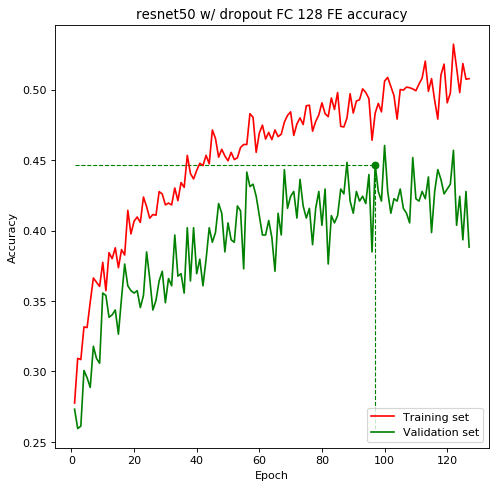

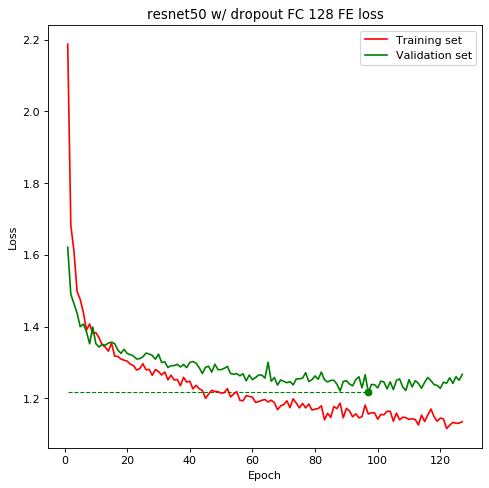

In [16]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [11]:
resnet50_ft_1layer = models.load_model('resnet50_fe_drop_128_4cl_best.h5')
# Fine tuning: unfreeze the last convolutional layer
for layer in resnet50_ft_1layer.get_layer('resnet50').layers:
    if layer.name.startswith('conv5_block3_3_conv','conv5_block3_3_bn'):
        print('true')
        layer.trainable = True
    else:
        print('false')
        layer.trainable = False

# Recompile the model ()
resnet50_ft_1layer.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

resnet50_ft_1layer.summary()
resnet50_ft_1layer.get_layer('resnet50').summary()

ResourceExhaustedError: OOM when allocating tensor with shape[131072,2048] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Mul] name: dense_2_2/kernel/Initializer/random_uniform/mul/

In [3]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'resnet50_ft_1layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [7]:
# Train
history_ft = resnet50_ft_1layer.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1613 - accuracy: 0.4902
Epoch 00001: val_loss improved from inf to 1.23752, saving model to resnet50_ft_1layer_4cl_best.h5
11/11 [==============================] - 26s 2s/step - loss: 1.1629 - accuracy: 0.4874 - val_loss: 1.2375 - val_accuracy: 0.4227
Epoch 2/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1660 - accuracy: 0.4750
Epoch 00002: val_loss did not improve from 1.23752
11/11 [==============================] - 21s 2s/step - loss: 1.1526 - accuracy: 0.4822 - val_loss: 1.2482 - val_accuracy: 0.4055
Epoch 3/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1321 - accuracy: 0.4898
Epoch 00003: val_loss improved from 1.23752 to 1.23415, saving model to resnet50_ft_1layer_4cl_best.h5
11/11 [==============================

Epoch 29/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1763 - accuracy: 0.4818
Epoch 00029: val_loss did not improve from 1.23372
11/11 [==============================] - 19s 2s/step - loss: 1.1753 - accuracy: 0.4797 - val_loss: 1.2525 - val_accuracy: 0.4107
Epoch 30/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1455 - accuracy: 0.5039
Epoch 00030: val_loss did not improve from 1.23372
11/11 [==============================] - 20s 2s/step - loss: 1.1480 - accuracy: 0.5028 - val_loss: 1.2467 - val_accuracy: 0.4003
Epoch 31/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1318 - accuracy: 0.5102
Epoch 00031: val_loss improved from 1.23372 to 1.22465, saving model to resnet50_ft_1layer_4cl_best.h5
11/11 [==============================] - 24s 2s/step - loss: 1.1277 - accuracy: 0.5142 - val_loss: 1.2247 - val_accuracy: 0.4399
Epoch 32/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1202 - accuracy: 0.5098
Epoch 00032: val_loss di

Epoch 59/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1428 - accuracy: 0.5098
Epoch 00059: val_loss did not improve from 1.22465
11/11 [==============================] - 19s 2s/step - loss: 1.1468 - accuracy: 0.5050 - val_loss: 1.2378 - val_accuracy: 0.4141
Epoch 60/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1307 - accuracy: 0.5055
Epoch 00060: val_loss did not improve from 1.22465
11/11 [==============================] - 19s 2s/step - loss: 1.1349 - accuracy: 0.5019 - val_loss: 1.2427 - val_accuracy: 0.4141
Epoch 61/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1293 - accuracy: 0.4977
Epoch 00061: val_loss did not improve from 1.22465
11/11 [==============================] - 20s 2s/step - loss: 1.1268 - accuracy: 0.5050 - val_loss: 1.2546 - val_accuracy: 0.4347
Epoch 00061: early stopping


In [8]:
# Save
models.save_model(resnet50_ft_1layer, 'resnet50_ft_1layer_4cl_end.h5')

In [9]:
# History of accuracy and loss
tra_loss_fe = history_ft.history['loss']
tra_acc_fe = history_ft.history['accuracy']
val_loss_fe = history_ft.history['val_loss']
val_acc_fe = history_ft.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_resnet50_ft_1layer = models.load_model('resnet50_ft_1layer_4cl_best.h5')
test_loss_fe, test_acc_fe = resnet50_ft_1layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_ft_1layer.evaluate(test_images, test_labels, verbose=False)

print("resnet50 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet50 Fine Tuning

Epoch [end]: 61
Epoch [opt]: 31
Valid accuracy [end]: 0.4347
Valid accuracy [opt]: 0.4399
Test accuracy [end]:  0.4305
Test accuracy [opt]:  0.4550
Valid loss [end]: 1.2546
Valid loss [opt]: 1.2247
Test loss [end]:  1.1895
Test loss [opt]:  1.1778


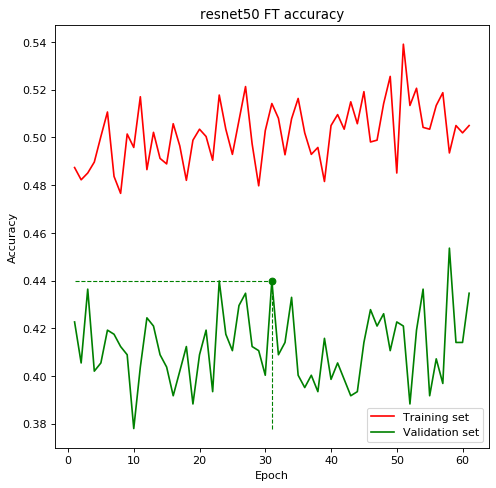

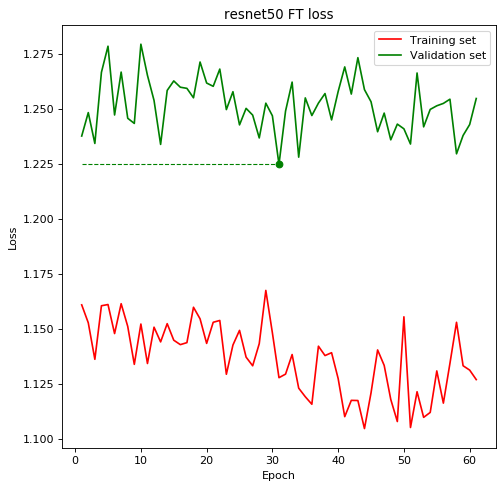

In [10]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();